In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention_gl as SelfAttention,CrossAttention_gl as CrossAttention
import sys,os
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
dnf300 = pd.read_json('evaluation_set/deepnofakes/dnf_300/combined_300.json').T
dnf_eval = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V2.json')
dnf_eval.columns = ['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls'] 
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_array_id.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_vector_array_id.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
dnf_eval.keys(), dnf300.keys(), len(articles.keys()), len(article_vectors.keys())

(Index(['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type',
        'urls'],
       dtype='object'),
 Index(['authors', 'evidence', 'headline', 'id', 'reason', 'type', 'urls'], dtype='object'),
 300,
 300)

In [4]:
num_splits = 5
kf = KFold(n_splits=num_splits)
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 2000
max_sentences = 0
for idx in articles.keys():
    num = len(articles[idx])
    if num>=max_sentences:
        max_sentences = num
        
max_sentences

35

In [5]:
titles = sorted(dnf300.headline.unique())
len(titles)

300

In [6]:
test_titles = sorted(dnf_eval.headline.unique())

In [7]:
titles = sorted(dnf300.headline.unique())
non_test_titles = np.array(list(set(titles)-set(test_titles)))


In [8]:
indices = []
for train_index, val_index in kf.split(non_test_titles):
    indices.append([train_index,val_index])

In [9]:

train_index, val_index = indices[np.random.randint(0,num_splits)]
print(train_index,val_index)
val_titles = non_test_titles[val_index]
train_titles = non_test_titles[train_index]
len(train_titles),len(val_titles),len(test_titles)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249] [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 

(200, 50, 50)

In [10]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [11]:

def datagen_dnf(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        idx = idx.strip()
        
            
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        if mode=='test':
            hd = dnf_eval[dnf_eval.headline==idx]['headline'].values[0].lower()
            ar_id = dnf_eval[dnf_eval.headline==idx]['id'].values[0]
            cl = dnf_eval[dnf_eval.headline==idx]['claims'].values[0]
            ar_claims.append(cl)
            
        else:
            try:
                hd = dataframe[dataframe.headline==idx]['headline'].values[0].lower()
                ar_id = dataframe[dataframe.headline==idx]['id'].values[0]
                ar_claims.append('None')
            except Exception as ex:
                print(ex)
                print(idx)
        sentences = articles[ar_id]
        vectors = article_vectors[ar_id]
        hds.append(hd)
        ar_sentences.append(sentences)
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
                ,'claims':np.array(ar_claims)
                ,'sentences':np.array(ar_sentences)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
            counter=0
 

In [12]:
tdg = datagen_dnf(train_batchsize,dnf300,mode='train')
vdg = datagen_dnf(val_batchsize,dnf300,mode='val')
test_dg = datagen_dnf(test_batchsize,dnf300,mode='test')

In [13]:
x,y = next(test_dg)

In [14]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 35, 300)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 35, 16)       14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 35, 16)       0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 35, 32)       1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

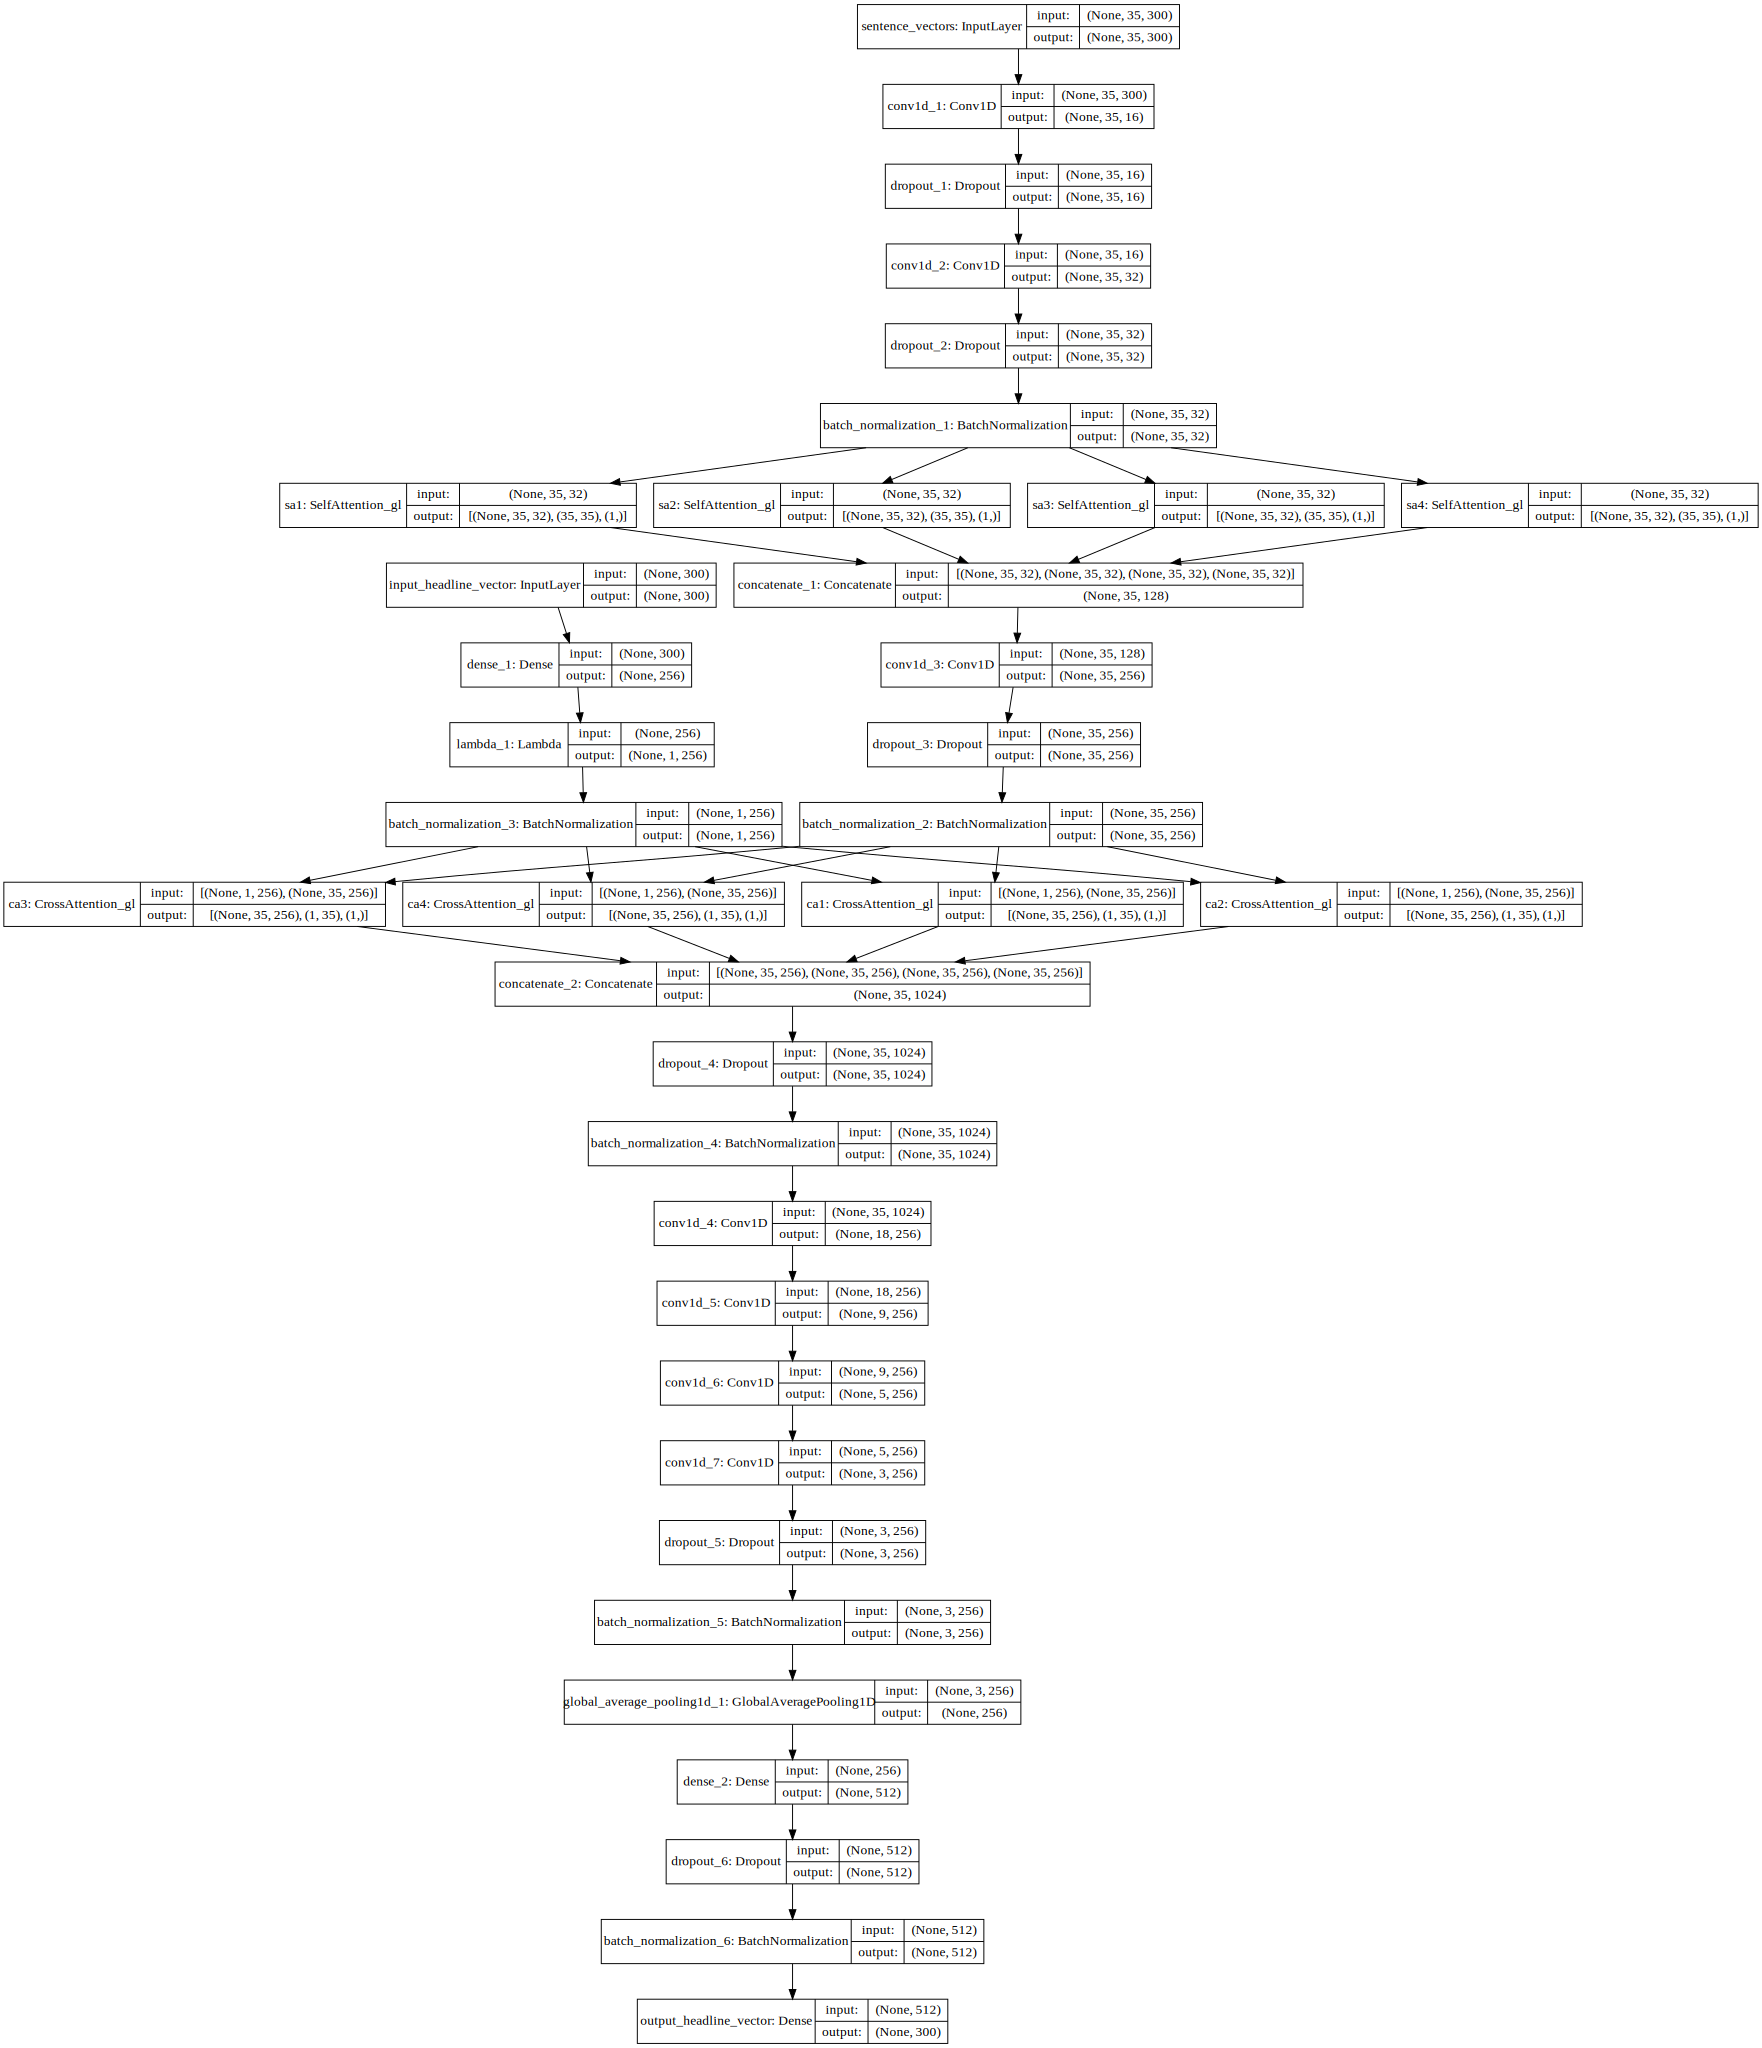

In [15]:
def build_model():
    inp_sentence_vectors = Input(shape=(max_sentences, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]), name = 'sa1')(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]), name = 'sa2')(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]), name = 'sa3')(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]), name = 'sa4')(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
#     repeat = RepeatVector(50)(gap)
#     lstm = LSTM(256,return_sequences=True)(repeat)
    dense1 = Dense(512,activation='relu')(gap)
    dense1 = Dropout(0.5)(dense1)
    dense1 = BatchNormalization()(dense1)
    gen_hd_vector = Dense(300,activation='linear', name='output_headline_vector')(dense1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='mse')
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [16]:
dt = datetime.now()
mc = ModelCheckpoint('weights/dnf300_sa_sent_hd_vector_gl.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/dnf300_sa_sent_hd_vector_gl/{0}'.format(dt.timestamp()),write_graph=True)

In [17]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 1/2000
4/4 [==============================] - 8s 2s/step - loss: 0.0335 - val_loss: 0.0362
Epoch 2/2000
4/4 [==============================] - 0s 46ms/step - loss: 0.0318 - val_loss: 0.0349
Epoch 3/2000
4/4 [==============================] - 0s 48ms/step - loss: 0.0334 - val_loss: 0.0349
Epoch 4/2000
4/4 [==============================] - 1s 224ms/step - loss: 0.0331 - val_loss: 0.0346
Epoch 5/2000
4/4 [==============================] - 2s 439ms/step - loss: 0.0326 - val_loss: 0.0321
Epoch 6/2000
4/4 [==============================] - 2s 395ms/step - loss: 0.0317 - val_loss: 0.0341
Epoch 7/2000
4/4 [==============================] - 2s 389ms/step - loss: 0.0314 - val_loss: 0.0347
Epoch 8/2000
4/4 [==============================] - 2s 409ms/step - loss: 0.0300 - val_loss: 0.0300
Epoch 9/2000
4/4 [==============================] - 2s 403ms/step - loss: 0.0302 - val_loss: 0.0299
Epoch 10/2000
4/4 [==============================] - 2s 407ms/step - loss: 0.0303 - val_loss: 0.0293
Epoc

4/4 [==============================] - 2s 437ms/step - loss: 0.0130 - val_loss: 0.0162
Epoch 83/2000
4/4 [==============================] - 2s 424ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 84/2000
4/4 [==============================] - 2s 463ms/step - loss: 0.0122 - val_loss: 0.0140
Epoch 85/2000
4/4 [==============================] - 2s 460ms/step - loss: 0.0127 - val_loss: 0.0121
Epoch 86/2000
4/4 [==============================] - 2s 451ms/step - loss: 0.0127 - val_loss: 0.0129
Epoch 87/2000
4/4 [==============================] - 2s 425ms/step - loss: 0.0127 - val_loss: 0.0121
Epoch 88/2000
4/4 [==============================] - 2s 414ms/step - loss: 0.0123 - val_loss: 0.0140
Epoch 89/2000
4/4 [==============================] - 2s 456ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 90/2000
4/4 [==============================] - 2s 456ms/step - loss: 0.0129 - val_loss: 0.0127
Epoch 91/2000
4/4 [==============================] - 2s 408ms/step - loss: 0.0119 - val_loss: 0.0125
Epoc

4/4 [==============================] - 3s 772ms/step - loss: 0.0105 - val_loss: 0.0131
Epoch 163/2000
4/4 [==============================] - 3s 652ms/step - loss: 0.0108 - val_loss: 0.0117
Epoch 164/2000
4/4 [==============================] - 3s 701ms/step - loss: 0.0109 - val_loss: 0.0119
Epoch 165/2000
4/4 [==============================] - 3s 686ms/step - loss: 0.0106 - val_loss: 0.0117
Epoch 166/2000
4/4 [==============================] - 3s 738ms/step - loss: 0.0101 - val_loss: 0.0104
Epoch 167/2000
4/4 [==============================] - 2s 619ms/step - loss: 0.0100 - val_loss: 0.0106
Epoch 168/2000
4/4 [==============================] - 2s 609ms/step - loss: 0.0106 - val_loss: 0.0134
Epoch 169/2000
4/4 [==============================] - 2s 557ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 170/2000
4/4 [==============================] - 2s 564ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 171/2000
4/4 [==============================] - 2s 536ms/step - loss: 0.0105 - val_loss: 0.

4/4 [==============================] - 3s 723ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 243/2000
4/4 [==============================] - 3s 744ms/step - loss: 0.0099 - val_loss: 0.0109
Epoch 244/2000
4/4 [==============================] - 3s 774ms/step - loss: 0.0114 - val_loss: 0.0119
Epoch 245/2000
4/4 [==============================] - 3s 813ms/step - loss: 0.0110 - val_loss: 0.0091
Epoch 246/2000
4/4 [==============================] - 3s 626ms/step - loss: 0.0107 - val_loss: 0.0095
Epoch 247/2000
4/4 [==============================] - 2s 571ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 248/2000
4/4 [==============================] - 3s 722ms/step - loss: 0.0099 - val_loss: 0.0131
Epoch 249/2000
4/4 [==============================] - 3s 681ms/step - loss: 0.0102 - val_loss: 0.0108
Epoch 250/2000
4/4 [==============================] - 3s 684ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 251/2000
4/4 [==============================] - 3s 628ms/step - loss: 0.0108 - val_loss: 0.

4/4 [==============================] - 3s 782ms/step - loss: 0.0108 - val_loss: 0.0130
Epoch 323/2000
4/4 [==============================] - 3s 743ms/step - loss: 0.0106 - val_loss: 0.0111
Epoch 324/2000
4/4 [==============================] - 3s 639ms/step - loss: 0.0115 - val_loss: 0.0107
Epoch 325/2000
4/4 [==============================] - 3s 697ms/step - loss: 0.0100 - val_loss: 0.0119
Epoch 326/2000
4/4 [==============================] - 3s 672ms/step - loss: 0.0108 - val_loss: 0.0107
Epoch 327/2000
4/4 [==============================] - 3s 711ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 328/2000
4/4 [==============================] - 3s 686ms/step - loss: 0.0098 - val_loss: 0.0111
Epoch 329/2000
4/4 [==============================] - 3s 700ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 330/2000
4/4 [==============================] - 3s 732ms/step - loss: 0.0104 - val_loss: 0.0120
Epoch 331/2000
4/4 [==============================] - 4s 960ms/step - loss: 0.0100 - val_loss: 0.

4/4 [==============================] - 6s 1s/step - loss: 0.0098 - val_loss: 0.0104
Epoch 405/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0102 - val_loss: 0.0120
Epoch 406/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0106
Epoch 407/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0097
Epoch 408/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0106
Epoch 409/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0098 - val_loss: 0.0115
Epoch 410/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0116 - val_loss: 0.0108
Epoch 411/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0104 - val_loss: 0.0113
Epoch 412/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0101 - val_loss: 0.0111
Epoch 413/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0096 - val_loss: 0.0096
Epoch 414/2000
4/4 [=====

Epoch 487/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0111 - val_loss: 0.0112
Epoch 488/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0098 - val_loss: 0.0107
Epoch 489/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0111
Epoch 490/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0112 - val_loss: 0.0092
Epoch 491/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0104 - val_loss: 0.0104
Epoch 492/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0111 - val_loss: 0.0110
Epoch 493/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0107 - val_loss: 0.0121
Epoch 494/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0119 - val_loss: 0.0103
Epoch 495/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0099 - val_loss: 0.0091
Epoch 496/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0098 - val_loss: 0.0101
Epoch 497/

4/4 [==============================] - 5s 1s/step - loss: 0.0108 - val_loss: 0.0125
Epoch 570/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0121
Epoch 571/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0108 - val_loss: 0.0128
Epoch 572/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0109 - val_loss: 0.0104
Epoch 573/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0103 - val_loss: 0.0108
Epoch 574/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0111 - val_loss: 0.0113
Epoch 575/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0103 - val_loss: 0.0123
Epoch 576/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0096 - val_loss: 0.0107
Epoch 577/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0126
Epoch 578/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0102 - val_loss: 0.0110
Epoch 579/2000
4/4 [=====

Epoch 652/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0111 - val_loss: 0.0120
Epoch 653/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0107 - val_loss: 0.0106
Epoch 654/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0097
Epoch 655/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0110 - val_loss: 0.0097
Epoch 656/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0112 - val_loss: 0.0097
Epoch 657/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0120
Epoch 658/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0104 - val_loss: 0.0111
Epoch 659/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0108 - val_loss: 0.0127
Epoch 660/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0091
Epoch 661/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0113 - val_loss: 0.0090
Epoch 662/

4/4 [==============================] - 6s 1s/step - loss: 0.0101 - val_loss: 0.0108
Epoch 735/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0103 - val_loss: 0.0115
Epoch 736/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0103 - val_loss: 0.0105
Epoch 737/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0099 - val_loss: 0.0119
Epoch 738/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0104 - val_loss: 0.0098
Epoch 739/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0103 - val_loss: 0.0117
Epoch 740/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0106 - val_loss: 0.0109
Epoch 741/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0096 - val_loss: 0.0102
Epoch 742/2000
4/4 [==============================] - 4s 924ms/step - loss: 0.0106 - val_loss: 0.0111
Epoch 743/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0099 - val_loss: 0.0113
Epoch 744/2000
4/4 [==

Epoch 817/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0103 - val_loss: 0.0120
Epoch 818/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0115 - val_loss: 0.0101
Epoch 819/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0108 - val_loss: 0.0112
Epoch 820/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0118 - val_loss: 0.0125
Epoch 821/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0097 - val_loss: 0.0119
Epoch 822/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0115
Epoch 823/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0096 - val_loss: 0.0124
Epoch 824/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0102 - val_loss: 0.0125
Epoch 825/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0110
Epoch 826/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0107 - val_loss: 0.0106
Epoch 827/

4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0103
Epoch 900/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0118 - val_loss: 0.0120
Epoch 901/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0108 - val_loss: 0.0130
Epoch 902/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0101
Epoch 903/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0104 - val_loss: 0.0115
Epoch 904/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0112 - val_loss: 0.0114
Epoch 905/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0101 - val_loss: 0.0110
Epoch 906/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0107 - val_loss: 0.0100
Epoch 907/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0109 - val_loss: 0.0104
Epoch 908/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0107 - val_loss: 0.0096
Epoch 909/2000
4/4 [=====

Epoch 982/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0103 - val_loss: 0.0109
Epoch 983/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0105
Epoch 984/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0113 - val_loss: 0.0117
Epoch 985/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0106 - val_loss: 0.0110
Epoch 986/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0108 - val_loss: 0.0113
Epoch 987/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0104 - val_loss: 0.0124
Epoch 988/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0119 - val_loss: 0.0110
Epoch 989/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0117 - val_loss: 0.0113
Epoch 990/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0104 - val_loss: 0.0110
Epoch 991/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0105 - val_loss: 0.0109
Epoch 992/

4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0101
Epoch 1065/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0103 - val_loss: 0.0108
Epoch 1066/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0100 - val_loss: 0.0118
Epoch 1067/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0113 - val_loss: 0.0120
Epoch 1068/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0109 - val_loss: 0.0113
Epoch 1069/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0102 - val_loss: 0.0115
Epoch 1070/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0095 - val_loss: 0.0115
Epoch 1071/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0111 - val_loss: 0.0114
Epoch 1072/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0100 - val_loss: 0.0105
Epoch 1073/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0110 - val_loss: 0.0107
Epoch 1074/2000


4/4 [==============================] - 6s 2s/step - loss: 0.0103 - val_loss: 0.0132
Epoch 1147/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0103 - val_loss: 0.0097
Epoch 1148/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0101 - val_loss: 0.0120
Epoch 1149/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0112 - val_loss: 0.0109
Epoch 1150/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0108 - val_loss: 0.0121
Epoch 1151/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0108 - val_loss: 0.0110
Epoch 1152/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0121
Epoch 1153/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0099 - val_loss: 0.0111
Epoch 1154/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0103 - val_loss: 0.0101
Epoch 1155/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0107 - val_loss: 0.0105
Epoch 1156/2000


4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0111
Epoch 1229/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0112 - val_loss: 0.0100
Epoch 1230/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0098
Epoch 1231/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0116 - val_loss: 0.0119
Epoch 1232/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0109
Epoch 1233/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0112 - val_loss: 0.0093
Epoch 1234/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0114
Epoch 1235/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0111 - val_loss: 0.0100
Epoch 1236/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0114 - val_loss: 0.0107
Epoch 1237/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0104 - val_loss: 0.0106
Epoch 1238/2000


4/4 [==============================] - 6s 1s/step - loss: 0.0117 - val_loss: 0.0111
Epoch 1311/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0098 - val_loss: 0.0115
Epoch 1312/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0111 - val_loss: 0.0103
Epoch 1313/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0118 - val_loss: 0.0109
Epoch 1314/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0109 - val_loss: 0.0115
Epoch 1315/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0104 - val_loss: 0.0113
Epoch 1316/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0112 - val_loss: 0.0115
Epoch 1317/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0102 - val_loss: 0.0095
Epoch 1318/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0106 - val_loss: 0.0111
Epoch 1319/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0107
Epoch 1320/2000


4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0112
Epoch 1393/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0101 - val_loss: 0.0110
Epoch 1394/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0109
Epoch 1395/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0106 - val_loss: 0.0118
Epoch 1396/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0104
Epoch 1397/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0108 - val_loss: 0.0114
Epoch 1398/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0103 - val_loss: 0.0094
Epoch 1399/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0101 - val_loss: 0.0124
Epoch 1400/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0108 - val_loss: 0.0113
Epoch 1401/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0100 - val_loss: 0.0087
Epoch 1402/2000


4/4 [==============================] - 6s 1s/step - loss: 0.0104 - val_loss: 0.0101
Epoch 1475/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0119 - val_loss: 0.0117
Epoch 1476/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0103 - val_loss: 0.0106
Epoch 1477/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0106 - val_loss: 0.0111
Epoch 1478/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0100 - val_loss: 0.0116
Epoch 1479/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0101 - val_loss: 0.0122
Epoch 1480/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0099 - val_loss: 0.0109
Epoch 1481/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0119 - val_loss: 0.0111
Epoch 1482/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0122
Epoch 1483/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0103 - val_loss: 0.0114
Epoch 1484/2000


4/4 [==============================] - 6s 1s/step - loss: 0.0101 - val_loss: 0.0096
Epoch 1557/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0112
Epoch 1558/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0100 - val_loss: 0.0118
Epoch 1559/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0100 - val_loss: 0.0111
Epoch 1560/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0119 - val_loss: 0.0108
Epoch 1561/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0109 - val_loss: 0.0137
Epoch 1562/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0112 - val_loss: 0.0112
Epoch 1563/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0100 - val_loss: 0.0117
Epoch 1564/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0105 - val_loss: 0.0106
Epoch 1565/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0109 - val_loss: 0.0104
Epoch 1566/2000


4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0123
Epoch 1639/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0103
Epoch 1640/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0109 - val_loss: 0.0131
Epoch 1641/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0113
Epoch 1642/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0111 - val_loss: 0.0133
Epoch 1643/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0100 - val_loss: 0.0118
Epoch 1644/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0107 - val_loss: 0.0123
Epoch 1645/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0106 - val_loss: 0.0119
Epoch 1646/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0103 - val_loss: 0.0121
Epoch 1647/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0098 - val_loss: 0.0116
Epoch 1648/2000


4/4 [==============================] - 6s 2s/step - loss: 0.0099 - val_loss: 0.0097
Epoch 1721/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0123
Epoch 1722/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0104 - val_loss: 0.0108
Epoch 1723/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0119 - val_loss: 0.0116
Epoch 1724/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0097 - val_loss: 0.0115
Epoch 1725/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0107 - val_loss: 0.0099
Epoch 1726/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0104 - val_loss: 0.0104
Epoch 1727/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0110
Epoch 1728/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0099 - val_loss: 0.0108
Epoch 1729/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0111 - val_loss: 0.0126
Epoch 1730/2000


4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0111
Epoch 1803/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0099 - val_loss: 0.0117
Epoch 1804/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0106 - val_loss: 0.0102
Epoch 1805/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0108 - val_loss: 0.0118
Epoch 1806/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0115 - val_loss: 0.0095
Epoch 1807/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0119
Epoch 1808/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0109 - val_loss: 0.0108
Epoch 1809/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0100 - val_loss: 0.0106
Epoch 1810/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0109 - val_loss: 0.0114
Epoch 1811/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0098 - val_loss: 0.0117
Epoch 1812/2000


4/4 [==============================] - 6s 1s/step - loss: 0.0111 - val_loss: 0.0107
Epoch 1885/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0112 - val_loss: 0.0111
Epoch 1886/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0110
Epoch 1887/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0101 - val_loss: 0.0107
Epoch 1888/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0114 - val_loss: 0.0112
Epoch 1889/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0116 - val_loss: 0.0124
Epoch 1890/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0116
Epoch 1891/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0109 - val_loss: 0.0122
Epoch 1892/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0095 - val_loss: 0.0108
Epoch 1893/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0106 - val_loss: 0.0106
Epoch 1894/2000


4/4 [==============================] - 6s 2s/step - loss: 0.0098 - val_loss: 0.0124
Epoch 1967/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0102 - val_loss: 0.0132
Epoch 1968/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0112 - val_loss: 0.0114
Epoch 1969/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0106 - val_loss: 0.0111
Epoch 1970/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0104
Epoch 1971/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0108
Epoch 1972/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0100 - val_loss: 0.0114
Epoch 1973/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0102 - val_loss: 0.0105
Epoch 1974/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0112 - val_loss: 0.0100
Epoch 1975/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0101
Epoch 1976/2000


In [18]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [19]:
# df_res = pd.DataFrame(hist.history)

In [20]:
# df_res[['loss','val_loss']].plot()

In [21]:
# df_res[['acc','val_acc']].plot()

# Evalutate SST

In [22]:
model.load_weights('weights/dnf300_sa_sent_hd_vector_gl.hdf5')
model.evaluate_generator(test_dg,steps=5,pickle_safe = True)

/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<generator..., use_multiprocessing=True, steps=5)`
  


0.010333957150578499

In [23]:
x,y = next(test_dg)
pred = model.predict(x)

In [24]:
x['headline']

array(["george soros: trump will win popular vote by a landslide but clinton victory a 'done deal'",
       'reddit users declare war on hillary’s paid internet trolls',
       'erdoğan: us, the founder of isis',
       'us officials see no link between trump and russia',
       'assange confirms: wikileaks didn’t get emails from russian govt',
       'us threatens military hacks on russia’s electric, communications grids over election',
       'fbi director comey’s ‘leaked’ memo explains why he’s reopening the clinton email case',
       'trump accuses obama, hillary clinton of founding daesh',
       'fbi director comey’s ‘leaked’ memo explains why he’s reopening the clinton email case',
       'he’s never sold an original painting until now…and this one’s going in the white house',
       "physician confirms hillary clinton has parkinson's disease",
       "hillary clinton wore 'secret earpiece' during commander-in-chief forum",
       'erdoğan: us, the founder of isis',
       "doj

In [25]:
test_idx = np.random.randint(0,50)
display(x['headline'][test_idx])

'hillary personally ordered ‘donald duck’ troll campaign'

In [26]:
x['sentences'][test_idx]


['Hillary Clinton personally ordered a consultant to use a nonprofit group to troll the Trump campaign with a ‘Donald Duck’ mascot, according to the Democratic operatives who say they arranged it with a nonprofit organization.',
 'When Breitbart News’ Washington political editor, Matthew Boyle, confronted Mook about Creamer and his firm in the spin room after the third presidential debate, Mook claimed: “They’ve never worked for our campaign.”',
 'When asked if Clinton had ever discussed the controversial political operations with Creamer directly, Mook replied: “I don’t think so.”',
 'Now, however, O’Keefe and Project Veritas have released video of Creamer claiming that Clinton directly approved one of his more bizarre plans — an effort to attract media attention and incite violence by dressing an activist in a Donald Duck costume and sending that activist into Trump events, emphasizing the argument that Trump was “ducking” releasing his tax returns.',
 'The action, if true, would be 

# Model Test

In [27]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 35, 300)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 35, 16)       14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 35, 16)       0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 35, 32)       1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [28]:

_, b1, g1 = model_1.predict(x)
_, b2, g2 = model_2.predict(x)
_, b3, g3 = model_3.predict(x)
_, b4, g4 = model_4.predict(x)

In [29]:
g1,g2,g3,g4

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32))

In [30]:
b = b1+b2+b3+b4

In [31]:
best_N = 5
t = b[test_idx][0][:len(x['sentences'][test_idx])].argsort()[-best_N:][::-1]
t

array([7, 6, 5, 4, 3])

In [32]:
print(len(x['sentences'][test_idx]))
b[test_idx][0][:len(x['sentences'][test_idx])].sum()

8


0.0

In [33]:
display(x['headline'][test_idx])
display(x['claims'][test_idx])

'hillary personally ordered ‘donald duck’ troll campaign'

['Hillary Clinton personally ordered a consultant to use a nonprofit group to troll the Trump campaign with a ‘Donald Duck’ mascot, according to the Democratic operatives who say they arranged it with a nonprofit organization.',
 'Now, however, O’Keefe and Project Veritas have released video of Creamer claiming that Clinton directly approved one of his more bizarre plans — an effort to attract media attention and incite violence by dressing an activist in a Donald Duck costume and sending that activist into Trump events, emphasizing the argument that Trump was “ducking” releasing his tax returns.',
 'The action, if true, would be a black-letter violation of federal election law, which prohibits presidential campaigns from coordinating activities with outside groups that can collect unlimited ‘dark money’ from contributors – and don’t pay taxes on what they collect.',
 '‘In the end, it was the candidate, Hillary Clinton, the future president of the United States, who wanted ducks on the

In [34]:
for s in t:
    if s>=len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

7 : So by God we would get ducks on the ground,’ Creamer says in the video.
6 : ‘In the end, it was the candidate, Hillary Clinton, the future president of the United States, who wanted ducks on the ground.
5 : Project Veritas Action video footage shows Robert Creamer, a convicted felon who was forced out of his executive role at the liberal consultancy Democracy Partners, saying Clinton chose the duck stunt.
4 : The action, if true, would be a black-letter violation of federal election law, which prohibits presidential campaigns from coordinating activities with outside groups that can collect unlimited ‘dark money’ from contributors – and don’t pay taxes on what they collect.
3 : Now, however, O’Keefe and Project Veritas have released video of Creamer claiming that Clinton directly approved one of his more bizarre plans — an effort to attract media attention and incite violence by dressing an activist in a Donald Duck costume and sending that activist into Trump events, emphasizing t

In [35]:
print(len(x['sentences'][test_idx]))
h_s_attended_vector = b[test_idx][0][:len(x['sentences'][test_idx])]
h_s_attended_vector.sum()

8


0.0

In [36]:
df_h_s_attended_vector = pd.DataFrame(h_s_attended_vector)


xw = df_h_s_attended_vector.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
xw_scaled = min_max_scaler.fit_transform(xw)
df_h_s_attended_vector = pd.DataFrame(xw_scaled)

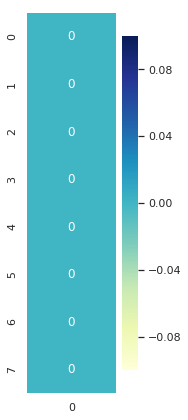

In [37]:
sns.set(rc={'figure.figsize':(2.0,7.0)})
sns.heatmap(df_h_s_attended_vector, annot=True, cmap='YlGnBu', )

# Between Sentences

In [38]:
model_s1 = Model(model.inputs,model.get_layer(name='sa1').output)
model_s2 = Model(model.inputs,model.get_layer(name='sa2').output)
model_s3 = Model(model.inputs,model.get_layer(name='sa3').output)
model_s4 = Model(model.inputs,model.get_layer(name='sa4').output)
model_s1.summary()
model_s2.summary()
model_s3.summary()
model_s4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_vectors (InputLayer (None, 35, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 16)            14416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 32)            1568      
_________________________________________________________________
dropout_2 (Dropout)          (None, 35, 32)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 32)            128       
_________________________________________________________________
sa1 (SelfAttention_gl)       [(None, 35, 32), (35, 35) 2378      
Total para

In [39]:
_, sb1, sg1 = model_s1.predict([x['sentence_vectors'],x['input_headline_vector']])
_, sb2, sg2 = model_s2.predict(x)
_, sb3, sg3 = model_s3.predict(x)
_, sb4, sg4 = model_s4.predict(x)

In [40]:
sg1,sg2, sg3, sg4

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32))

In [41]:
sb = sb1[test_idx]+sb2[test_idx]+sb3[test_idx]+sb4[test_idx]
sb = sb[:len(x['sentences'][test_idx]),:len(x['sentences'][test_idx])]

sb.shape

(8, 8)

In [42]:
df_sb = pd.DataFrame(sb)


# zx = df_sb.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# zx_scaled = min_max_scaler.fit_transform(zx)
# df_sb = pd.DataFrame(zx_scaled)

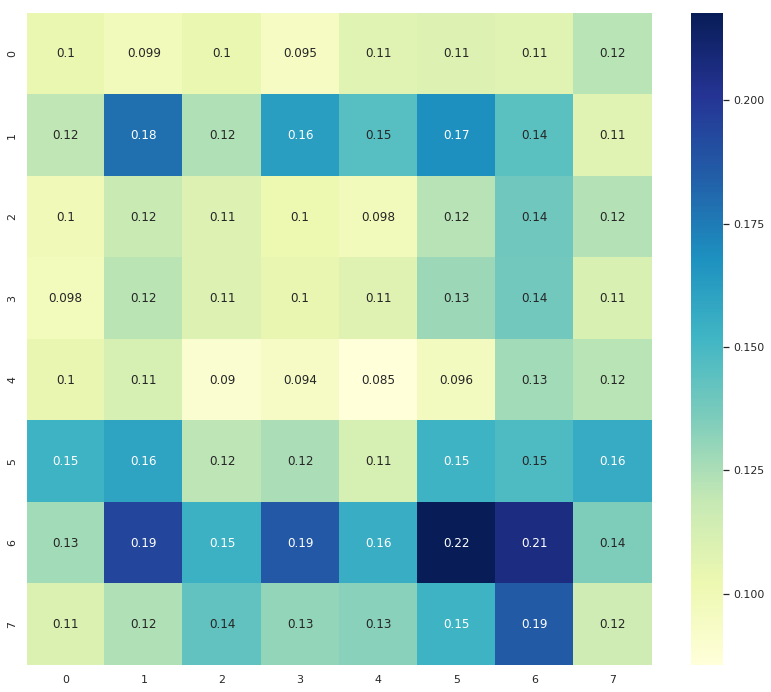

In [43]:
sns.set(rc={'figure.figsize':(14.0,12.0)})
sns.heatmap(pd.DataFrame(df_sb),annot=True,cmap='YlGnBu')

In [44]:
pd.DataFrame(x['sentences'][test_idx])

,0
0,"Hillary Clinton personally ordered a consultant to use a nonprofit group to troll the Trump campaign with a ‘Donald Duck’ mascot, according to the Democratic operatives who say they arranged it with a nonprofit organization."
1,"When Breitbart News’ Washington political editor, Matthew Boyle, confronted Mook about Creamer and his firm in the spin room after the third presidential debate, Mook claimed: “They’ve never worked for our campaign.”"
2,"When asked if Clinton had ever discussed the controversial political operations with Creamer directly, Mook replied: “I don’t think so.”"
3,"Now, however, O’Keefe and Project Veritas have released video of Creamer claiming that Clinton directly approved one of his more bizarre plans — an effort to attract media attention and incite violence by dressing an activist in a Donald Duck costume and sending that activist into Trump events, emphasizing the argument that Trump was “ducking” releasing his tax returns."
4,"The action, if true, would be a black-letter violation of federal election law, which prohibits presidential campaigns from coordinating activities with outside groups that can collect unlimited ‘dark money’ from contributors – and don’t pay taxes on what they collect."
5,"Project Veritas Action video footage shows Robert Creamer, a convicted felon who was forced out of his executive role at the liberal consultancy Democracy Partners, saying Clinton chose the duck stunt."
6,"‘In the end, it was the candidate, Hillary Clinton, the future president of the United States, who wanted ducks on the ground."
7,"So by God we would get ducks on the ground,’ Creamer says in the video."
